### Praca Domowa 3
------------------
**Budowanie**
Szymon Gut, Jan Krężel

In [222]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

from pandas.api.types import is_numeric_dtype

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

#### 0. Wczytywanie i podział danych danych

In [558]:
df = pd.read_csv('data.csv')

Z jakiegoś powodu wszystkie nazwy kolumn mają poprzedzającą spację, więc ją usuniemy.

In [559]:
df.columns = df.columns.str.lstrip()

In [560]:
def split_data(X,y, random_state = 42):
    
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, stratify=y, test_size=0.3, random_state=random_state
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_val, y_val, stratify=y_val, test_size=0.3, random_state=random_state
    )
    return X_train, X_val, X_test, y_train, y_val, y_test 

In [561]:
y = np.array(df['Bankrupt?'])
X = df.drop(['Bankrupt?'], axis=1)

In [562]:
X_train, X_val, X_test, y_train, y_val, y_test = split_data(X,y)

In [40]:
print('X_train:', X_train.shape)
print('y_train:', y_train.shape)
print('X_val:', X_val.shape)
print('y_val:', y_val.shape)
print('y_test:', X_test.shape)
print('y_test:', y_test.shape)

X_train: (4773, 95)
y_train: (4773,)
X_val: (1432, 95)
y_val: (1432,)
y_test: (614, 95)
y_test: (614,)


#### 1. Krótkie EDA

In [556]:
X_train.describe()


,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
count,4773.000000,4773.000000,4773.000000,4773.000000,4773.000000,4773.000000,4773.000000,4773.000000,4773.000000,4773.000000,...,4773.000000,4.773000e+03,4773.000000,4773.000000,4773.000000,4773.000000,4773.000000,4773.000000,4773.0,4773.000000
mean,0.504262,0.557497,0.552759,0.607735,0.607715,0.998757,0.797263,0.809187,0.303747,0.781438,...,0.807204,1.980390e+07,0.623760,0.607733,0.840443,0.280316,0.027715,0.565339,1.0,0.047192
std,0.060874,0.065915,0.062145,0.017043,0.017025,0.014483,0.011973,0.010917,0.011899,0.011813,...,0.040504,3.865474e+08,0.012689,0.017043,0.009648,0.010208,0.018559,0.014131,0.0,0.049090
min,0.024277,0.000000,0.033514,0.000000,0.000000,0.000000,0.000000,0.084286,0.235090,0.000000,...,0.000000,0.000000e+00,0.000000,0.000000,0.344652,0.133503,0.000000,0.000000,1.0,0.000000
25%,0.476088,0.535052,0.527116,0.600463,0.600455,0.998969,0.797385,0.809310,0.303467,0.781566,...,0.796561,9.066675e-04,0.623635,0.600459,0.840095,0.276953,0.026791,0.565158,1.0,0.024383
50%,0.502462,0.559474,0.552010,0.605940,0.605904,0.999022,0.797462,0.809375,0.303525,0.781634,...,0.810467,2.069045e-03,0.623876,0.605936,0.841148,0.278794,0.026809,0.565254,1.0,0.033730
75%,0.534637,0.588149,0.582901,0.613651,0.613593,0.999093,0.797575,0.809467,0.303584,0.781729,...,0.826101,5.242451e-03,0.624168,0.613651,0.842336,0.281491,0.026914,0.565729,1.0,0.052676
max,1.000000,1.000000,1.000000,0.665151,0.666023,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,9.820000e+09,1.000000,0.665149,1.000000,0.652347,1.000000,1.000000,1.0,1.000000


In [42]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4773 entries, 3295 to 6313
Data columns (total 95 columns):
 #   Column                                                   Non-Null Count  Dtype  
---  ------                                                   --------------  -----  
 0   ROA(C) before interest and depreciation before interest  4773 non-null   float64
 1   ROA(A) before interest and % after tax                   4773 non-null   float64
 2   ROA(B) before interest and depreciation after tax        4773 non-null   float64
 3   Operating Gross Margin                                   4773 non-null   float64
 4   Realized Sales Gross Margin                              4773 non-null   float64
 5   Operating Profit Rate                                    4773 non-null   float64
 6   Pre-tax net Interest Rate                                4773 non-null   float64
 7   After-tax net Interest Rate                              4773 non-null   float64
 8   Non-industry income and e

Czy są jakieś braki danych?

In [43]:
X_train.isna().mean(axis=0).any()

False

Ile mamy unikalnych wartości?

In [102]:
X.columns[X_train.nunique() == 1]

Index(['Net Income Flag'], dtype='object')

Kolumna Net Income Flag ma tylko jedną wartość. Warto będzie ją usunąć, ponieważ nie będzie miała ona wpływu na przewidywanie.

Rozkład zmiennej Celu

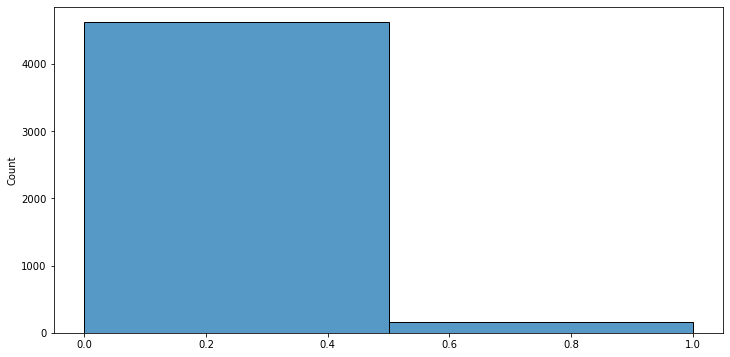

In [44]:
plt.figure(figsize=(12,6))
sns.histplot(data = y_train, bins=2)
plt.show()

#### 2. Preprocessing

Wpierw sprawdźmy czy są jacyś outlierzy

In [48]:
def count_outliers(X : pd.DataFrame, column):
    Q1 = X[column].quantile(0.25)
    Q3 = X[column].quantile(0.75)
    IQR = Q3 - Q1
    outlier_count = ((X[column] < (Q1 - 1.5 * IQR)) | (X[column] > (Q3 + 1.5 * IQR))).sum()
    major_outlier_count = ((X[column] < (Q1 - 3 * IQR)) | (X[column] > (Q3 + 3 * IQR))).sum()
    return outlier_count, major_outlier_count

In [53]:
outliers_df = pd.DataFrame(columns=['Column', 'Outliers', 'Major Outliers'])
for column in X_train.columns:
    outlier_count, major_outlier_count = count_outliers(X, column)
    outliers_df = outliers_df.append({'Column': column, 'Outliers': outlier_count, 'Major Outliers': major_outlier_count}, ignore_index=True)
    # print(f"{column}:\t{outlier_count},{major_outlier_count}")
outliers_df

,Column,Outliers,Major Outliers
0,ROA(C) before interest and depreciation before...,391,63
1,ROA(A) before interest and % after tax,561,125
2,ROA(B) before interest and depreciation after tax,432,79
3,Operating Gross Margin,320,82
4,Realized Sales Gross Margin,318,82
...,...,...,...
90,Liability to Equity,404,140
91,Degree of Financial Leverage (DFL),1503,998
92,Interest Coverage Ratio (Interest expense to E...,1421,859
93,Net Income Flag,0,0


Czy jakieś zmienne są odwrotnie skorelowane ze zmienną celu?

In [109]:
df_train = X_train.copy()
df_train['Bankrupt?'] = y_train
correlation = df_train.corr()
negatively_correlated_columns = df_train.columns[correlation['Bankrupt?'] < 0]
len(negatively_correlated_columns)

65

Usuwanie zmiennych skorelowanych

Wpierw wyznaczamy feature importance (funkcja mutual_info_classif) dla każdej zmiennej, a następnie dla zmiennych skorelowanych (>0.65) usuwamy tę mniej informatywną. Dokładniejszy opis procesu w komentarzach funkcji

In [136]:
mi = mutual_info_classif(X_train, y_train)
mi = pd.Series(mi, index = X_train.columns)

In [338]:
def remove_highly_correlated(X, mi, threshold=0.65):
    # znajdź pary (różnych) zmiennych o korelacji większej niż threshold
    correlation = X.corr()
    correlation = correlation.melt(ignore_index=False).reset_index(drop=False).rename(columns={'index':'Var 1', 'variable': 'Var 2', 'value': 'Corr'})
    correlation = correlation[(np.abs(correlation['Corr']) > threshold) & (correlation['Var 1'] != correlation['Var 2'])].sort_values(by='Corr', ascending=False)

    # idąc od najbardziej skorelowanych odrzuć tę mniej ważną
    # jest to bardzo prosty i naiwny algorytm, ponieważ nie maksymalizuje on średniej pozostałej wartości feature importance
    # ani nie minimalizuje liczby usuniętych zmiennych

    removed_features = set()
    for _, row in correlation.iterrows():
        var_1 = row['Var 1']
        var_2 = row['Var 2']
        if (var_1 in removed_features or var_2 in removed_features):
            continue # do not remove unecessary columns
        fi_1 = mi[var_1]
        fi_2 = mi[var_2]
        if (fi_2 < fi_1):
            removed_features.add(var_2)
        else:
            removed_features.add(var_1)

    return X.drop(list(removed_features), axis=1), removed_features

    

Poniżej przedstawiony jest wykres feature importance dla 10 najlepszych zmiennych (aby zachować czytelność)

Do trenowania modelu wybierzemy 30 najlepszych, po usunięciu zmiennych silnie skorelowanych.

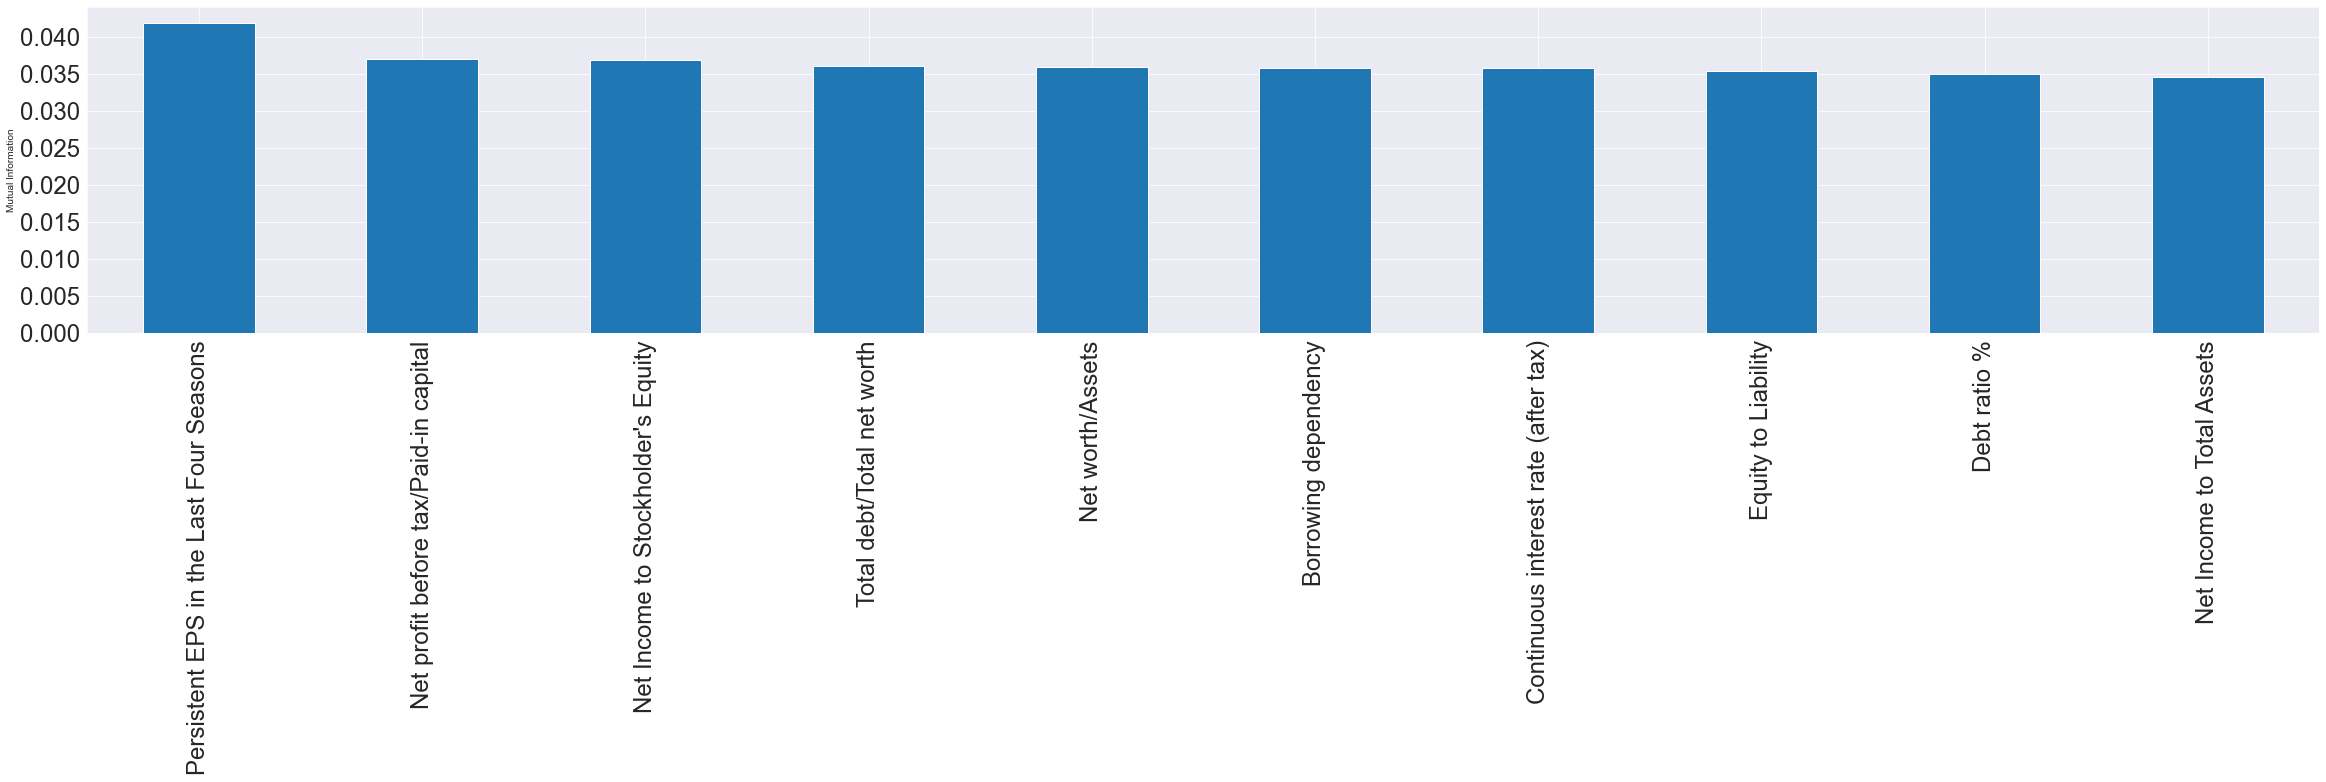

In [331]:
plt.figure(figsize=(40, 6))

mi = pd.Series(mi, index=X_train.columns)
top_10_features = mi.sort_values(ascending=False).head(10)
top_10_features.plot.bar(fontsize=24)
plt.ylabel('Mutual Information')
plt.show()

In [339]:
X_train_reduced = remove_highly_correlated(X, mi)[0]

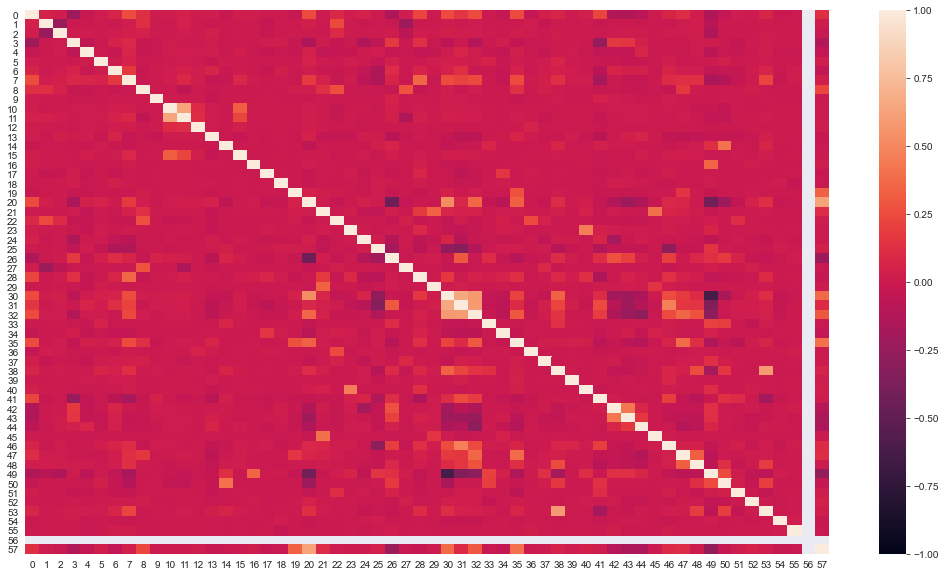

In [348]:
plt.figure(figsize=(18, 10))
sns.heatmap(X_train_reduced.corr(), vmin=-1, vmax=1,
        xticklabels=np.arange(X_train_reduced.columns.shape[0]), # liczby dla czytelności, poniważ nazwy kolumn są zbyt długie
        yticklabels=np.arange(X_train_reduced.columns.shape[0]))
plt.show()


Zmienna ```Net Income Flag``` nie jest w żaden sposób informatywna. Będziemy ją usuwać

In [349]:
X_train_reduced.columns[56]

'Net Income Flag'

#### 3. Pipeline

Teraz stworzymy pipeline, który obejmuje wszystkie wcześniej opisane transformacje

In [350]:
# Krok do usuwania Net Income Flag
class ColumnDropper:
    def __init__(self, column):
        self.column = column

    def fit(self, X, y = None):
        return self

    def transform(self, X, y = None):
        return X.drop(column, axis=1)

# Krok do wyrzucania zbyt skorelowanych zmiennych
class CorrelatedFeatureDropper:
    def __init__(self, threshold=0.65):
        self.threshold = threshold

    def fit(self, X, y):
        mi = mutual_info_classif(X, y)
        mi = pd.Series(mi, index=X.columns)
        self.dropped_columns = remove_highly_correlated(X, mi)[1]
        return self

    def transform(self, X, y = None):
        return X.drop(self.dropped_columns, axis=1)

# Zmiana korelacji ujemnej na dodatnią
class TrendTransformer:
    def __init__(self):
        return None

    def fit(self, X, y = None):
        df = X.copy()
        df['y'] = y
        correlation = df.corr()
        self.columns = df.columns[correlation['y'] < 0]
        return self

    def transform(self, X, y= None):
        X_copy = X.copy()
        for column in self.columns:
            X_copy[column] = -X[column]
        return X_copy

# Przycinanie outlierów
class OutlierClamper:
    def __init__(self, min_quantile = 0.025, max_quantile = 0.975):
        self.min_q = min_quantile
        self.max_q = max_quantile

    def fit(self, X, y = None):
        return self

    def transform(self, X : pd.DataFrame, y = None):
        X_copy = X.copy()
        for column in X.columns:
            if not is_numeric_dtype(X[column]):
                continue
            min_v = X[column].quantile(self.min_q)
            max_v = X[column].quantile(self.max_q)
            X_copy.loc[X[column] < min_v, column] = min_v
            X_copy.loc[X[column] > max_v, column] = max_v
        return X_copy

In [351]:
preprocessor = Pipeline(
    steps=[
        ('NIFDropper', ColumnDropper('Net Income Flag')),
        ('CorrelatedFeatureDropper', CorrelatedFeatureDropper()),
        ('OutlierClamper', OutlierClamper()),
        ('TrendTransformer', TrendTransformer()),
        ('MinMaxScaler', MinMaxScaler()),
        ('FeatureSelector', SelectKBest(mutual_info_classif, k=30)),
    ]
)

#### 4. Budowanie Modeli

In [403]:
def evaluate(model : Pipeline, X, y, suppress_output = False):
    y_pred = model.predict(X)
    if not suppress_output:
        
        print(f"Accuracy score: ", accuracy_score(y,y_pred))
        print("precision: ", precision_score(y,y_pred))
        print("recall: ", recall_score(y,y_pred))
        print("f1: ", f1_score(y,y_pred))

        sns.heatmap(confusion_matrix(y, y_pred), annot=True, fmt='g', xticklabels=["Positive", "Negative"], yticklabels=["Positive", "Negative"])
        plt.xlabel("Predicted Class")
        plt.ylabel("True Class")

    return f1_score(y,y_pred)

**Regresja logistyczna**

In [ ]:
lr = Pipeline(
    steps=[
        ('Preprocessor', preprocessor),
        ('LogisticRegressor', LogisticRegression(random_state=0))
    ],
)
lr.fit(X_train, y_train)

Accuracy score:  0.9720670391061452
precision:  0.8
recall:  0.17391304347826086
f1:  0.2857142857142857


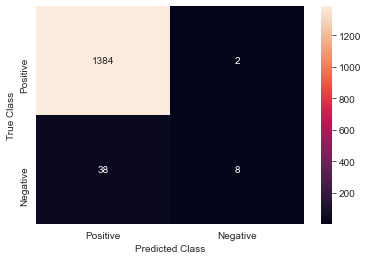

In [354]:
lr_f1 = evaluate(lr, X_val, y_val)

**XGBClassifier**

In [ ]:
xgbc = Pipeline(
    steps=[
        ('Preprocessor', preprocessor),
        ('XGBClassifier', XGBClassifier(n_estimators = 100, random_state=0, max_depth=25, use_label_encoder=False, eval_metric='logloss'))
    ],
)
xgbc.fit(X_train, y_train)

Accuracy score:  0.9692737430167597
precision:  0.5625
recall:  0.1956521739130435
f1:  0.2903225806451613


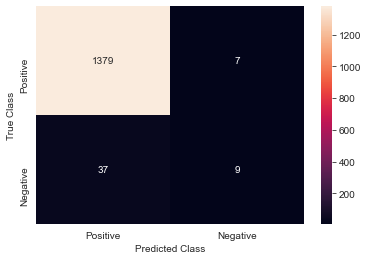

In [385]:
xgbc_f1 = evaluate(xgbc, X_val, y_val)

**Random Forest Classifier**

In [ ]:
rfc = Pipeline(
    steps=[
        ('Preprocessor', preprocessor),
        ('RFC', RandomForestClassifier(n_estimators=100, criterion = 'entropy', random_state = 0))
    ],
)
rfc.fit(X_train, y_train)

Accuracy score:  0.9699720670391061
precision:  0.8
recall:  0.08695652173913043
f1:  0.1568627450980392


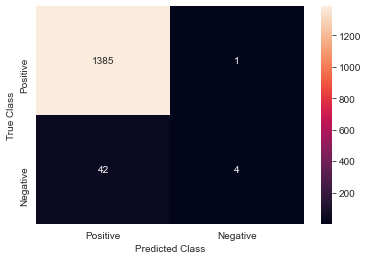

In [363]:
rfc_f1 = evaluate(rfc, X_val, y_val)

Widać, że ```precision``` i ```recall``` nie są wystarczająco wysokie. Jest to spowodowane bardzo małą liczbą obserwacji firm, które zbankrutowały (```Bankrupt?``` == 1).

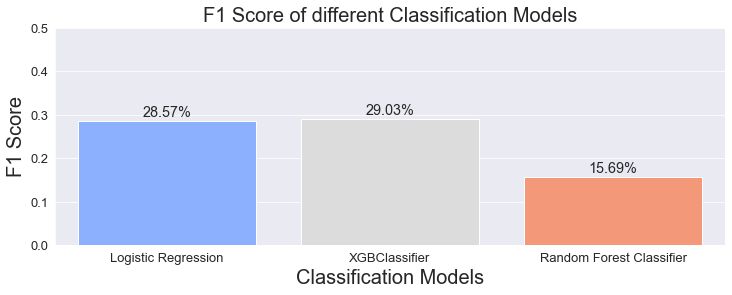

In [386]:
f1_scores=[lr_f1, xgbc_f1, rfc_f1]
models=["Logistic Regression", "XGBClassifier", "Random Forest Classifier"]

plt.figure(figsize=(12, 4))
sns.set_style("darkgrid")
ax = sns.barplot(x=models, y=f1_scores, palette = "coolwarm", saturation =1.5)
plt.xlabel("Classification Models", fontsize = 20 )
plt.ylabel("F1 Score", fontsize = 20)
plt.title("F1 Score of different Classification Models", fontsize = 20)
plt.xticks(fontsize = 13, horizontalalignment = 'center')
plt.yticks(fontsize = 13)
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{height:.2%}', (x + width/2, y + height + 0.01), ha='center', fontsize = 'x-large')
plt.ylim([0, 0.5])
plt.show()


Najlepiej (pod względem F1 Score) sprawuje się model XGBClassifier

#### 5. Dostrajanie hiperparametrów

Ponieważ preprocessing trwa dość długo to wpierw przerobimy dane używając naszego pipeline, a potem tak przerobione dane będzie dostarczać osobno do modeli z różnymi wartościami hiperparametrów.

In [389]:
X_train_processed = preprocessor.fit_transform(X_train, y_train)
X_val_processed = preprocessor.transform(X_val)

**Regresja Logistyczna**

Największym problemem naszych danych jest mała liczba obserwacji firm, które zbankrutowały. Możemy pomóc modelowi regresji podając odpowiednie wagi dla przewidywanych klas. Domyślnie ```LogisticRegressor``` nie używa żadnych wag.

In [396]:
lr_balanced = LogisticRegression(class_weight='balanced', random_state=0)
lr_balanced.fit(X_train_processed, y_train)

LogisticRegression(class_weight='balanced', random_state=0)

Accuracy score:  0.8701117318435754
precision:  0.18181818181818182
recall:  0.8695652173913043
f1:  0.30075187969924816


0.30075187969924816

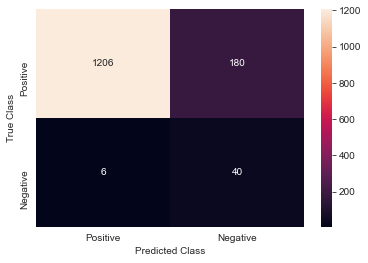

In [397]:
evaluate(lr_balanced, X_val_processed, y_val)

Wcześniej problemem były przypadki False Negative. Teraz problemem są przypadki False Positive jednak F1 Score się poprawił. Sprawdźmy czy uda nam się znaleźć jakąś optymalną wagę dla klas. W trybie ```Balanced``` wagi to 

    n_samples / (n_classes * np.bincount(y))

Czyli u nas


In [402]:
y_train.shape[0] / (2 * np.bincount(y_train))

array([ 0.51667027, 15.49675325])

Czyli mniej więcej 1:30. Zobaczmy czy uda nam się znaleźć jakiś lepszy stosunek wag. będziemy szuakć w przedziale 1:[0:30]

In [422]:
lr_f1_scores = np.empty(31)
for i in np.arange(0, 31):
    lr_hyper = LogisticRegression(class_weight={0:1, 1:i}, random_state=0, max_iter=200)
    lr_hyper.fit(X_train_processed, y_train)
    y_pred = lr_hyper.predict(X_val_processed)
    lr_f1_scores[i] = f1_score(y_val, y_pred)
    

Text(0, 0.5, 'F1 Score')

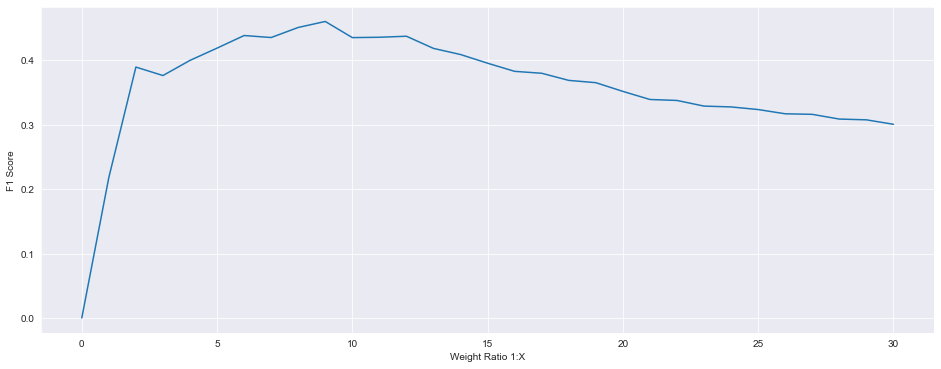

In [424]:
plt.figure(figsize=(16, 6))
sns.lineplot(x=np.arange(0, 31), y=lr_f1_scores)
plt.xlabel("Weight Ratio 1:X")
plt.ylabel("F1 Score")

Najlepszy wynik uzyskujemy dla stosunku 1:9. Zobaczmy jak wygląda Confusion Matrix dla tego parametru

Accuracy score:  0.9476256983240223
precision:  0.34408602150537637
recall:  0.6956521739130435
f1:  0.46043165467625896


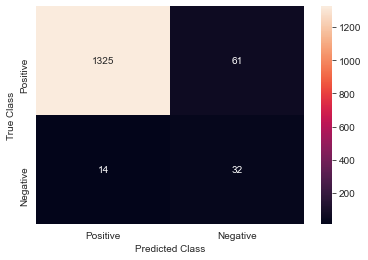

In [542]:
lr_hyper = LogisticRegression(class_weight={0:1, 1:9}, random_state=0, max_iter=200)
lr_hyper.fit(X_train_processed, y_train)
lr_f1_hyper = evaluate(lr_hyper, X_val_processed, y_val)

**XGBClassifier**
Dla XGBClassifer sprawdzimy znaczenie parametrów ```max_depth``` oraz ```learning_rate```

In [543]:
max_depths = np.arange(5, 15, 1)
learning_rates = np.logspace(-0.6, 0.6, 50)

xgbc_f1_scores_train = np.empty(shape=(max_depths.shape[0], learning_rates.shape[0]))       # bias
xgbc_f1_scores_val = np.empty(shape=(max_depths.shape[0], learning_rates.shape[0]))         # variance

In [464]:
from IPython.display import clear_output

In [544]:
# %%capture --no-stdout

for i, depth in enumerate(max_depths):
    for j, learning_rate in enumerate(learning_rates):
        clear_output(wait=True)
        print(f"Evaluating model {i * len(learning_rates) + j} of {len(learning_rates) * len(max_depths)}...\n")

        xgbc_hyper = XGBClassifier(
            random_state = 0, 
            max_depth=depth, 
            learning_rate=learning_rate, 
            n_estimators=10, 
            use_label_encoder=False, eval_metric='logloss')
        xgbc_hyper.fit(X_train_processed, y_train)

        xgbc_f1_scores_train[i, j] = f1_score(y_train, xgbc_hyper.predict(X_train_processed))
        xgbc_f1_scores_val[i, j] = f1_score(y_val, xgbc_hyper.predict(X_val_processed))


Evaluating model 499 of 500...



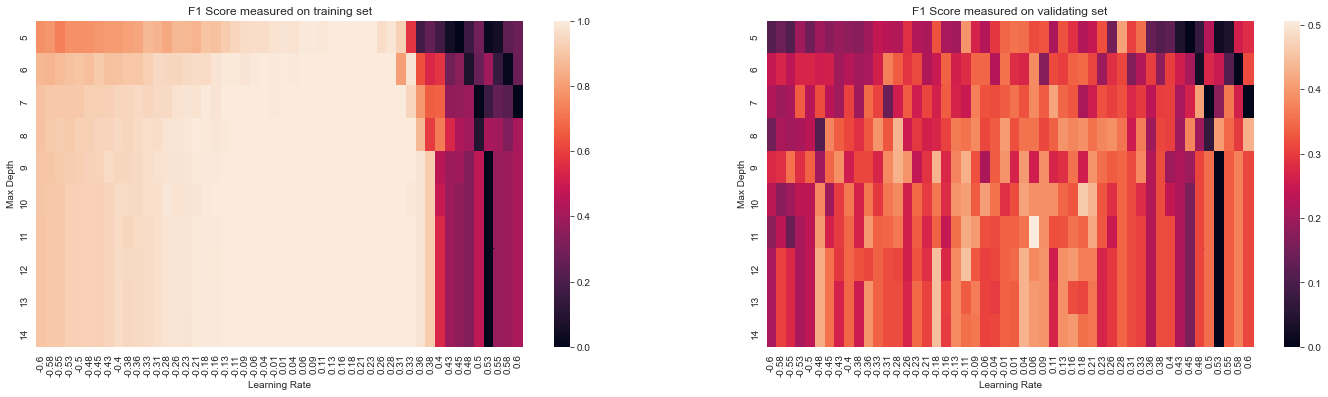

In [545]:
fig, axes = plt.subplots(1, 2, figsize=(24, 6))
axes[0].title.set_text("F1 Score measured on training set")
axes[1].title.set_text("F1 Score measured on validating set")

# Ucinam outlierów, aby lepiej było widać skalę problemu
sns.heatmap(ax = axes[0], data = xgbc_f1_scores_train, xticklabels=np.log10(learning_rates).round(2), yticklabels=max_depths)
sns.heatmap(ax = axes[1], data = xgbc_f1_scores_val, xticklabels=np.log10(learning_rates).round(2), yticklabels=max_depths)
axes[0].set(xlabel="Learning Rate", ylabel="Max Depth")
axes[1].set(xlabel="Learning Rate", ylabel="Max Depth")
plt.show()

Widzimy, że zdecydowanie większy wpływ ma tutaj ```Learning Rate``` i optymalny zakres to około 10^(0.06) (X_val)

In [546]:
argidx = np.unravel_index(xgbc_f1_scores_val.argmax(), (max_depths.shape[0], learning_rates.shape[0]))
argmax = max_depths[argidx[0]], learning_rates[argidx[1]]
argmax


(11, 1.1513953993264472)

Accuracy score:  0.9741620111731844
precision:  0.6551724137931034
recall:  0.41304347826086957
f1:  0.5066666666666666


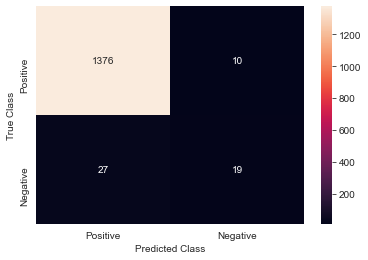

In [547]:
xgbc_hyper = XGBClassifier(
    random_state = 0,
    max_depth=argmax[0], 
    learning_rate=argmax[1], 
    n_estimators=10, 
    use_label_encoder=False, eval_metric='logloss')
xgbc_hyper.fit(X_train_processed, y_train)
xgbc_f1_hyper = evaluate(xgbc_hyper, X_val_processed, y_val)

**Random Forest Classifer**

Na koniec zajmiemy się Lasem Losowym. Tutaj także będziemy analizować ```max_depth```, ale zamiast ```learning_rate``` sprawdzimy ```min_samples_split```

In [548]:
max_depths = np.arange(5, 15, 1)
min_splits = np.logspace(start = -5, stop = -2, num=25)
rfc_f1_scores_train = np.empty(shape=(max_depths.shape[0], min_splits.shape[0]))    # bias
rfc_f1_scores_val = np.empty(shape=(max_depths.shape[0], min_splits.shape[0]))      # variance

In [549]:
for i, depth in enumerate(max_depths):
    for j, split in enumerate(min_splits):
        clear_output(wait=True)
        print(f"Evaluating model {i * len(min_splits) + j} of {len(min_splits) * len(max_depths)}...\n")
        rfc_hyper = RandomForestClassifier(random_state = 0, n_estimators=15, max_depth=depth, min_samples_split=split)
        rfc_hyper.fit(X_train_processed, y_train)

        rfc_f1_scores_train[i, j] = f1_score(y_train, rfc_hyper.predict(X_train_processed))
        rfc_f1_scores_val[i, j] = f1_score(y_val, rfc_hyper.predict(X_val_processed))

Evaluating model 249 of 250...



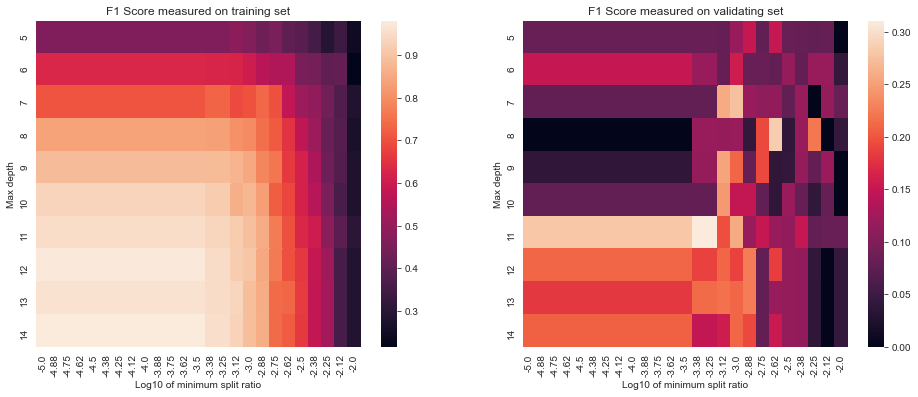

In [550]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].title.set_text("F1 Score measured on training set")
axes[1].title.set_text("F1 Score measured on validating set")

# Ucinam outlierów, aby lepiej było widać skalę problemu
sns.heatmap(ax = axes[0], data = rfc_f1_scores_train, xticklabels=np.log10(min_splits).round(2), yticklabels=max_depths)
sns.heatmap(ax = axes[1], data = rfc_f1_scores_val, xticklabels=np.log10(min_splits).round(2), yticklabels=max_depths)
axes[0].set(xlabel="Log10 of minimum split ratio", ylabel="Max depth")
axes[1].set(xlabel="Log10 of minimum split ratio", ylabel="Max depth")
plt.show()

Widzimy efekty przeuczenia się dla głębokich drzew oraz dla drzew, które dokonują bardzo drobnych podziałów.

In [551]:
argidx = np.unravel_index(rfc_f1_scores_val.argmax(), (max_depths.shape[0], min_splits.shape[0]))
argmax = max_depths[argidx[0]], min_splits[argidx[1]]
argmax

(11, 0.00042169650342858224)

Accuracy score:  0.9720670391061452
precision:  0.75
recall:  0.1956521739130435
f1:  0.3103448275862069


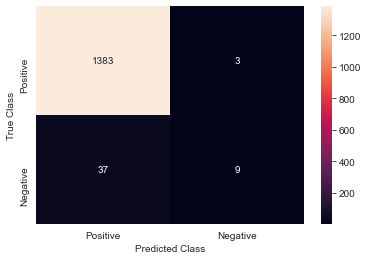

In [552]:
rfc_hyper = RandomForestClassifier(random_state = 0, n_estimators=15, max_depth=argmax[0], min_samples_split=argmax[1])
rfc_hyper.fit(X_train_processed, y_train)
rfc_f1_hyper = evaluate(rfc_hyper, X_val_processed, y_val)

Poprawione wyniki

In [553]:
scores_table = pd.DataFrame({
    'Model': ['LR', 'LR', 'XGBC', 'XGBC', 'RFC', 'RFC'], 
    'Optimised': ['NO', 'YES'] * 3, 
    'F1 Score': [lr_f1, lr_f1_hyper, xgbc_f1, xgbc_f1_hyper, rfc_f1, rfc_f1_hyper]})

<AxesSubplot:xlabel='Model', ylabel='F1 Score'>

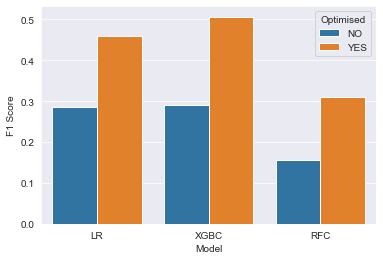

In [555]:
sns.barplot(data=scores_table, x = 'Model', y='F1 Score', hue='Optimised')

Oczywiście mierzenie tylko za pomocą ```F1 Score``` nie jest wystarczające. W zależności od tego co chcemy osiągnąć powinniśmy patrzeć na różne ewaluacje.

#### 6. Podsumowanie

Najlepiej sprawdzał się model XGBClassifer w szczególności po optymalizacji hiperparametrów. Regresja logistyczna jest zaraz za nim jednak dzięki możliwości ustawienia wag może okazać się skuteczniejsza dla danego problemu. To wynika z tego, że raczej będziemy woleli stwierdzić, że jakaś firma zbankrutuje i się mylić niż stwierdzić, że firma się utrzyma gdy w rzeczywistości niedługo upadnie. To jest szczególnie ważne np przy udzielaniu kredytów przez banki.

-------------
**Walidacja**

In [563]:
# może to chwilkę zająć
preprocessor.fit(X_train, y_train)
X_test_processed = preprocessor.transform(X_test)